In [13]:
import pandas as pd
import numpy as np
import re
import nltk

# For vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For clustering
from sklearn.cluster import KMeans

# For evaluation
from sklearn.metrics import silhouette_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize numerical features
from sklearn.preprocessing import StandardScaler

# Combine text vectors and numerical features
from scipy.sparse import hstack

from textblob import TextBlob



# Download NLTK data files (only the first time)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df = pd.read_csv('../data/akereviewsdataset.csv')

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join back into a string
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['text_'].apply(preprocess_text)


In [7]:
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust 'max_features' as needed
X_text = vectorizer.fit_transform(df['clean_text'])


In [10]:
# Assuming these columns exist in your DataFrame
numerical_features = ['sentiment_score', 'text_length', 'rating_deviation']

In [15]:
df['text_length'] = df['text_'].str.len()

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'text_' column
df['sentiment_score'] = df['text_'].apply(get_sentiment)

mean_rating = df['rating'].mean()
df['rating_deviation'] = df['rating'] - mean_rating


In [16]:
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_features])


X = hstack([X_text, X_num])


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # Adjust components as needed
X_reduced = pca.fit_transform(X.toarray())


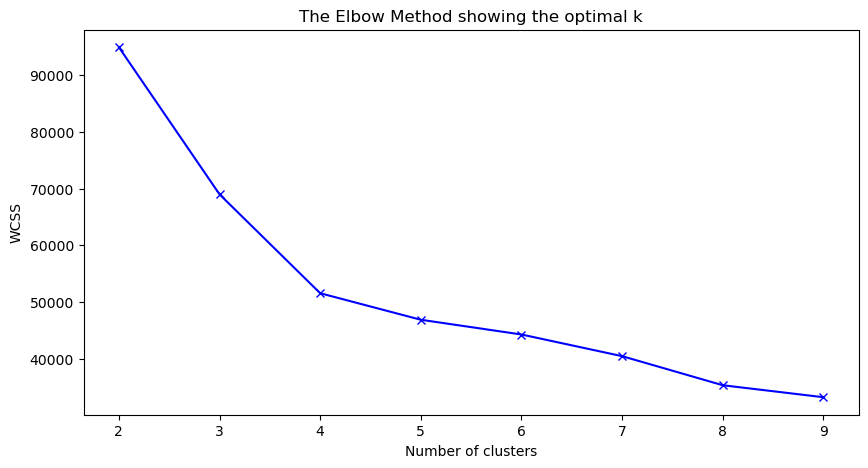

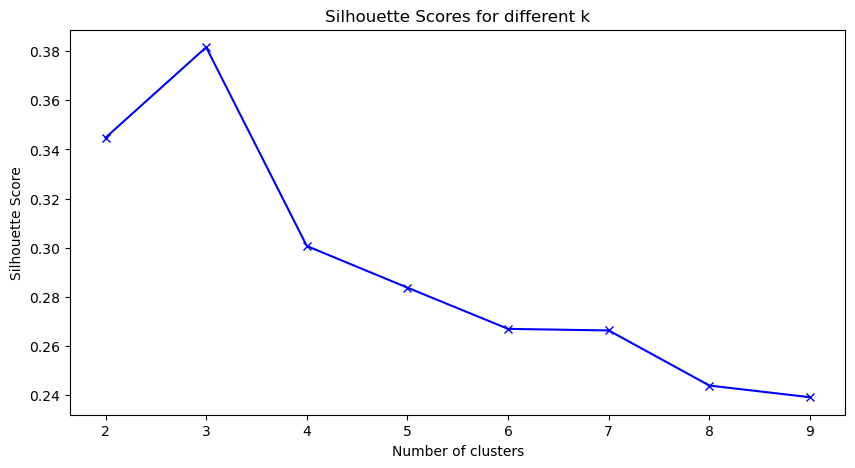

In [18]:
wcss = []
silhouette_scores = []
K = range(2, 10)  # Try cluster sizes from 2 to 9

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Square
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k')
plt.show()


In [19]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_reduced)
df['cluster'] = kmeans.labels_


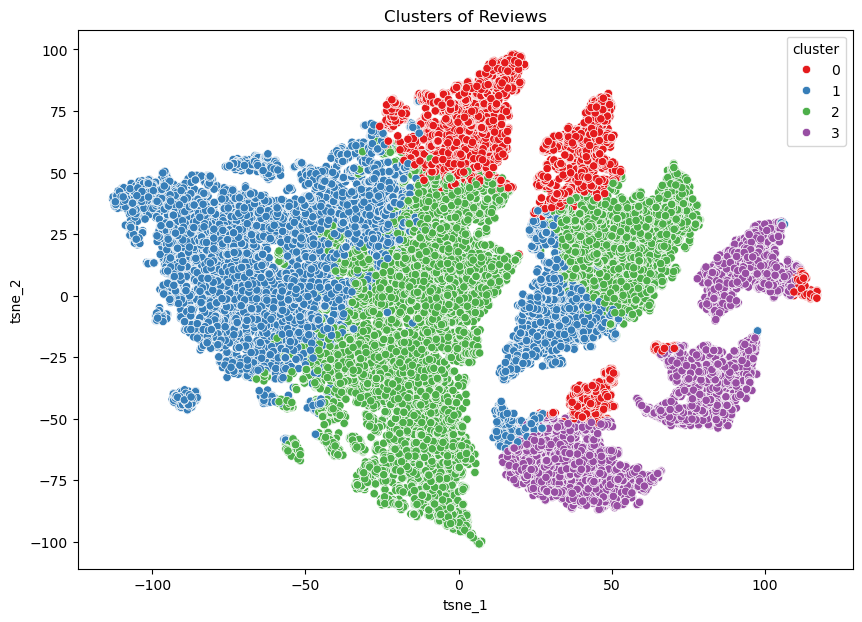

In [20]:
# Further reduce dimensions to 2D for visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

df['tsne_1'] = X_embedded[:,0]
df['tsne_2'] = X_embedded[:,1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='Set1')
plt.title('Clusters of Reviews')
plt.show()
